# SPP LAOS: Complete NLSQ → NUTS Workflow

> **Handbook:** See [SPP LAOS Workflow](../../docs/source/transforms/spp_decomposer.rst#complete-workflow) for pipeline implementation and [Rogers SPP Defaults](../../docs/source/transforms/spp_decomposer.rst#theory) for parameter selection guidance.

This notebook demonstrates the complete Sequence of Physical Processes (SPP) framework for
Large Amplitude Oscillatory Shear (LAOS) analysis using RheoJAX.

## Learning Objectives

After completing this notebook, you will be able to:
- Apply SPP decomposition to LAOS amplitude sweep data
- Extract yield stress scaling relationships using power-law fits
- Use SPPAmplitudeSweepPipeline for automated analysis
- Perform NLSQ → NUTS workflow for SPP parameter uncertainty
- Interpret convergence diagnostics for SPP models
- Understand divergence sources in hierarchical noise models

## SPP Theory Overview

The SPP framework (Rogers et al.) decomposes nonlinear stress responses into:
- **Elastic contribution**: Recoverable strain energy (in-phase with strain)
- **Viscous contribution**: Dissipated energy (in-phase with strain rate)

Key outputs:
- `sigma_sy`: Static yield stress (maximum elastic stress)
- `sigma_dy`: Dynamic yield stress (maximum viscous stress)  
- `S_factor`: Stiffening ratio (-1 to 1, 0 = linear)
- `T_factor`: Thickening ratio (-1 to 1, 0 = linear)

**Defaults**: n_harmonics=39, step_size=8, num_mode=2, wrapped strain-rate inference.

**Estimated Time:** 25-30 minutes

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import os
import sys

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.pipeline.workflows import SPPAmplitudeSweepPipeline
from rheojax.transforms import SPPDecomposer

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


## 1. Generate Synthetic LAOS Data

Create amplitude sweep data with power-law yielding behavior:
$$\sigma = A \cdot \gamma_0^n \cdot \sin(\omega t)$$

where $A=60$ Pa and $n=0.7$ (sublinear yielding).

In [2]:
# Experimental parameters
omega = 1.5  # rad/s
gamma_levels = jnp.array([0.1, 0.2, 0.4, 0.8, 1.6])  # strain amplitudes
n_points = 400  # points per cycle
t = jnp.linspace(0, 2 * jnp.pi / omega, n_points)

# Power-law yield parameters (ground truth)
A_true = 60.0  # Pa
n_true = 0.7   # exponent

def make_dataset(gamma_0):
    """Generate synthetic LAOS dataset with power-law yielding."""
    strain = gamma_0 * jnp.sin(omega * t)
    # Add slight nonlinearity for more realistic behavior
    stress = A_true * gamma_0**n_true * jnp.sin(omega * t)
    # Add small noise
    noise = np.random.normal(0, 0.5, len(t))
    return RheoData(
        x=np.array(t),
        y=np.array(stress) + noise,
        domain="time",
        metadata={"omega": float(omega), "gamma_0": float(gamma_0), "strain": np.array(strain)}
    )

np.random.seed(42)
datasets = [make_dataset(float(g)) for g in gamma_levels]
print(f"Created {len(datasets)} datasets at γ₀ = {list(gamma_levels)}")

Created 5 datasets at γ₀ = [Array(0.1, dtype=float64), Array(0.2, dtype=float64), Array(0.4, dtype=float64), Array(0.8, dtype=float64), Array(1.6, dtype=float64)]


## 2. Visualize Lissajous Curves

Lissajous (stress-strain) curves reveal nonlinear viscoelastic behavior:
- **Ellipse**: Linear viscoelastic
- **Distorted ellipse**: Nonlinear response

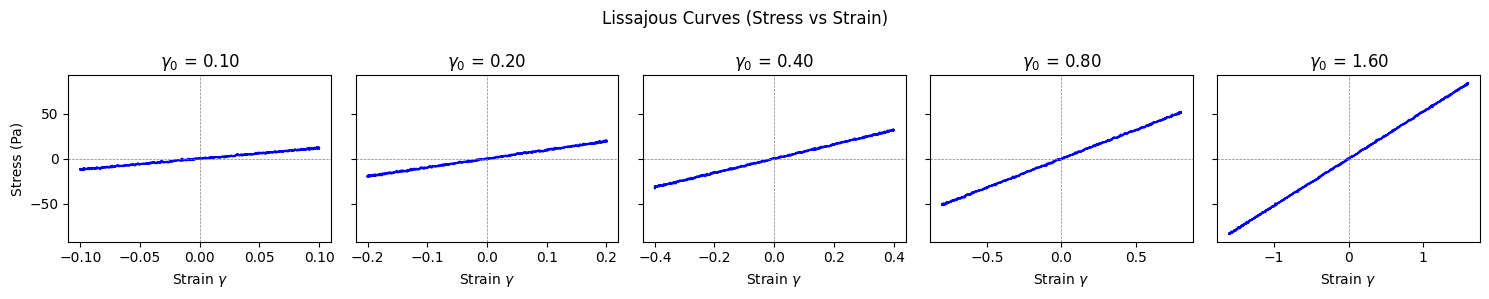

In [3]:
fig, axes = plt.subplots(1, len(datasets), figsize=(3*len(datasets), 3), sharey=True)
if len(datasets) == 1:
    axes = [axes]

for ax, ds, gamma in zip(axes, datasets, gamma_levels):
    strain = ds.metadata["strain"]
    stress = ds.y
    ax.plot(strain, stress, 'b-', lw=1.5)
    ax.set_xlabel(r'Strain $\gamma$')
    ax.set_title(f'$\\gamma_0$ = {gamma:.2f}')
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.axvline(0, color='gray', lw=0.5, ls='--')

axes[0].set_ylabel('Stress (Pa)')
fig.suptitle('Lissajous Curves (Stress vs Strain)', fontsize=12)
plt.tight_layout()
display(fig)
plt.close(fig)

## 3. SPP Decomposition (Single Amplitude)

Demonstrate the SPPDecomposer on a single dataset to understand the outputs.

In [4]:
# Select middle amplitude for demonstration
idx = len(datasets) // 2
demo_data = datasets[idx]
demo_gamma = float(gamma_levels[idx])

# Create decomposer with Rogers defaults
decomposer = SPPDecomposer(omega=float(omega), gamma_0=demo_gamma)
result = decomposer.transform(demo_data)

# Display key results
print(f"SPP Decomposition at γ₀ = {demo_gamma}:")
print(f"  Static yield stress (σ_sy):  {decomposer.results_['sigma_sy']:.3f} Pa")
print(f"  Dynamic yield stress (σ_dy): {decomposer.results_['sigma_dy']:.3f} Pa")
print(f"  Stiffening factor (S):       {decomposer.results_['S_factor']:.4f}")
print(f"  Thickening factor (T):       {decomposer.results_['T_factor']:.4f}")

SPP Decomposition at γ₀ = 0.4:
  Static yield stress (σ_sy):  31.491 Pa
  Dynamic yield stress (σ_dy): 31.332 Pa
  Stiffening factor (S):       0.3904
  Thickening factor (T):       1.0398


## 4. Amplitude Sweep Pipeline

Process all amplitudes and extract yield stress vs strain amplitude relationship.

In [5]:
# Run SPP amplitude sweep pipeline
pipeline = SPPAmplitudeSweepPipeline(omega=float(omega))
pipeline.run(datasets, gamma_0_values=list(map(float, gamma_levels)))

# Get yield stresses for all amplitudes
yield_data = pipeline.get_yield_stresses()
sigma_sy = yield_data["sigma_sy"]
sigma_dy = yield_data["sigma_dy"]

print("Amplitude Sweep Results:")
print(f"{'γ₀':>8} {'σ_sy (Pa)':>12} {'σ_dy (Pa)':>12}")
print("-" * 34)
for g, sy, dy in zip(gamma_levels, sigma_sy, sigma_dy):
    print(f"{float(g):>8.3f} {float(sy):>12.3f} {float(dy):>12.3f}")

Amplitude Sweep Results:
      γ₀    σ_sy (Pa)    σ_dy (Pa)
----------------------------------
   0.100       11.815       11.747
   0.200       19.338       19.549
   0.400       31.491       31.332
   0.800       50.950       51.173
   1.600       82.840       83.372


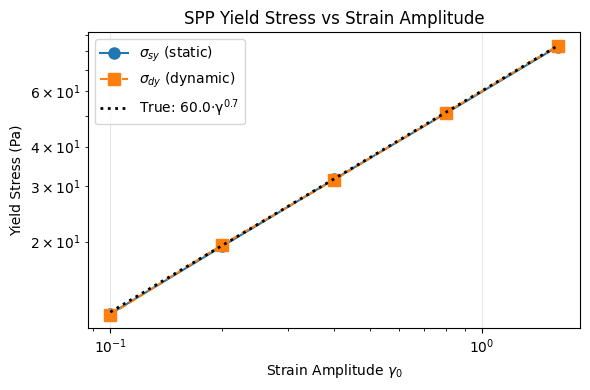

In [6]:
# Plot yield stress vs strain amplitude
fig, ax = plt.subplots(figsize=(6, 4))

ax.loglog(gamma_levels, sigma_sy, 'o-', label=r'$\sigma_{sy}$ (static)', markersize=8)
ax.loglog(gamma_levels, sigma_dy, 's--', label=r'$\sigma_{dy}$ (dynamic)', markersize=8)

# Reference power-law
gamma_ref = np.linspace(float(gamma_levels.min()), float(gamma_levels.max()), 100)
ax.loglog(gamma_ref, A_true * gamma_ref**n_true, 'k:', lw=2, 
          label=f'True: {A_true}·γ$^{{{n_true}}}$')

ax.set_xlabel(r'Strain Amplitude $\gamma_0$')
ax.set_ylabel('Yield Stress (Pa)')
ax.set_title('SPP Yield Stress vs Strain Amplitude')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting (Point Estimation)

Fit power-law model to yield stress data using fast NLSQ optimization.

In [7]:
# Fit power-law model: σ_sy = scale * γ^exp
pipeline.fit_model(bayesian=False, yield_type="static")
model = pipeline.get_model()

# Get fitted parameters
params = model.parameters
scale_nlsq = params["sigma_sy_scale"].value
exp_nlsq = params["sigma_sy_exp"].value

print("NLSQ Fit Results (Point Estimates):")
print(f"  σ_sy_scale: {scale_nlsq:.4f} Pa (true: {A_true})")
print(f"  σ_sy_exp:   {exp_nlsq:.4f} (true: {n_true})")

NLSQ Fit Results (Point Estimates):
  σ_sy_scale: 59.6651 Pa (true: 60.0)
  σ_sy_exp:   0.7017 (true: 0.7)


## 6. Bayesian Inference with NUTS

Quantify parameter uncertainty using Bayesian inference with warm-start from NLSQ.

In [8]:
# Bayesian inference with proper settings for convergence
# Key settings:
# - num_chains=4: Multiple chains enable proper R-hat computation
# - num_warmup=2000: More warmup for better adaptation
# - num_samples=2000: Enough samples per chain for reliable posterior estimates
# - target_accept_prob=0.99: Very high to minimize divergences
# - max_tree_depth=12: Allow deeper trees for complex posteriors
bayes = model.fit_bayesian(
    gamma_levels, 
    sigma_sy,
    test_mode="oscillation",
    num_chains=4,
    num_warmup=2000,           # More warmup for better step size adaptation
    num_samples=2000,
    target_accept_prob=0.99,   # Very high = very small steps = minimal divergences
    max_tree_depth=12,         # Allow deeper tree exploration
)

# Extract posterior statistics
print("\nBayesian Posterior Summary:")
print(f"{'Parameter':>15} {'Mean':>10} {'Std':>10} {'5%':>10} {'95%':>10}")
print("-" * 57)
for param in ["sigma_sy_scale", "sigma_sy_exp"]:
    if param in bayes.summary:
        s = bayes.summary[param]
        print(f"{param:>15} {s['mean']:>10.4f} {s['std']:>10.4f} "
              f"{s.get('q05', 0):>10.4f} "
              f"{s.get('q95', 0):>10.4f}")

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:02<2:19:16,  2.09s/it]

warmup:   0%|          | 2/4000 [00:04<2:22:05,  2.13s/it]

warmup:   0%|          | 5/4000 [00:04<43:13,  1.54it/s]  

warmup:   0%|          | 6/4000 [00:04<34:03,  1.95it/s]

warmup:   0%|          | 7/4000 [00:04<26:46,  2.49it/s]

warmup:   0%|          | 8/4000 [00:04<21:19,  3.12it/s]

warmup:   0%|          | 9/4000 [00:04<17:41,  3.76it/s]

warmup:   0%|          | 10/4000 [00:05<14:59,  4.44it/s]

warmup:   0%|          | 12/4000 [00:05<11:09,  5.96it/s]

warmup:   0%|          | 14/4000 [00:05<08:58,  7.40it/s]

warmup:   0%|          | 15/4000 [00:05<08:59,  7.38it/s]

warmup:   0%|          | 16/4000 [00:05<08:47,  7.56it/s]

warmup:   0%|          | 17/4000 [00:05<08:44,  7.59it/s]

warmup:   0%|          | 19/4000 [00:05<07:29,  8.87it/s]

warmup:   0%|          | 20/4000 [00:06<07:44,  8.57it/s]

warmup:   1%|          | 21/4000 [00:06<08:19,  7.97it/s]

warmup:   1%|          | 23/4000 [00:06<07:34,  8.75it/s]

warmup:   1%|          | 24/4000 [00:06<07:30,  8.82it/s]

warmup:   1%|          | 25/4000 [00:06<07:32,  8.79it/s]

warmup:   1%|          | 26/4000 [00:06<07:41,  8.62it/s]

warmup:   1%|          | 27/4000 [00:06<08:43,  7.59it/s]

warmup:   1%|          | 28/4000 [00:07<08:11,  8.07it/s]

warmup:   1%|          | 30/4000 [00:07<06:58,  9.48it/s]

warmup:   1%|          | 32/4000 [00:07<06:52,  9.62it/s]

warmup:   1%|          | 33/4000 [00:07<07:31,  8.79it/s]

warmup:   1%|          | 34/4000 [00:07<07:25,  8.89it/s]

warmup:   1%|          | 35/4000 [00:07<07:37,  8.67it/s]

warmup:   1%|          | 36/4000 [00:07<07:38,  8.65it/s]

warmup:   1%|          | 38/4000 [00:08<07:31,  8.77it/s]

warmup:   1%|          | 39/4000 [00:08<07:42,  8.57it/s]

warmup:   1%|          | 40/4000 [00:08<07:29,  8.82it/s]

warmup:   1%|          | 41/4000 [00:08<08:33,  7.71it/s]

warmup:   1%|          | 42/4000 [00:08<08:29,  7.76it/s]

warmup:   1%|          | 43/4000 [00:08<08:19,  7.93it/s]

warmup:   1%|          | 45/4000 [00:08<07:45,  8.50it/s]

warmup:   1%|          | 46/4000 [00:09<07:59,  8.25it/s]

warmup:   1%|          | 47/4000 [00:09<07:56,  8.30it/s]

warmup:   1%|          | 48/4000 [00:09<07:51,  8.38it/s]

warmup:   1%|          | 49/4000 [00:09<07:32,  8.72it/s]

warmup:   1%|▏         | 50/4000 [00:09<08:03,  8.16it/s]

warmup:   1%|▏         | 51/4000 [00:09<07:47,  8.44it/s]

warmup:   1%|▏         | 52/4000 [00:09<07:33,  8.71it/s]

warmup:   1%|▏         | 53/4000 [00:09<08:09,  8.07it/s]

warmup:   1%|▏         | 54/4000 [00:10<07:51,  8.36it/s]

warmup:   1%|▏         | 55/4000 [00:10<07:31,  8.74it/s]

warmup:   1%|▏         | 57/4000 [00:10<06:29, 10.11it/s]

warmup:   1%|▏         | 58/4000 [00:10<06:46,  9.69it/s]

warmup:   1%|▏         | 59/4000 [00:10<06:55,  9.49it/s]

warmup:   2%|▏         | 60/4000 [00:10<07:13,  9.09it/s]

warmup:   2%|▏         | 62/4000 [00:10<06:51,  9.57it/s]

warmup:   2%|▏         | 63/4000 [00:10<06:54,  9.50it/s]

warmup:   2%|▏         | 64/4000 [00:11<06:50,  9.59it/s]

warmup:   2%|▏         | 65/4000 [00:11<06:48,  9.64it/s]

warmup:   2%|▏         | 67/4000 [00:11<06:36,  9.92it/s]

warmup:   2%|▏         | 68/4000 [00:11<07:04,  9.27it/s]

warmup:   2%|▏         | 70/4000 [00:11<06:36,  9.91it/s]

warmup:   2%|▏         | 72/4000 [00:11<06:43,  9.73it/s]

warmup:   2%|▏         | 74/4000 [00:12<06:20, 10.33it/s]

warmup:   2%|▏         | 76/4000 [00:12<06:27, 10.12it/s]

warmup:   2%|▏         | 78/4000 [00:12<06:19, 10.32it/s]

warmup:   2%|▏         | 80/4000 [00:12<06:33,  9.97it/s]

warmup:   2%|▏         | 81/4000 [00:12<06:37,  9.85it/s]

warmup:   2%|▏         | 82/4000 [00:12<06:47,  9.63it/s]

warmup:   2%|▏         | 83/4000 [00:13<06:51,  9.52it/s]

warmup:   2%|▏         | 85/4000 [00:13<06:43,  9.71it/s]

warmup:   2%|▏         | 87/4000 [00:13<07:06,  9.18it/s]

warmup:   2%|▏         | 88/4000 [00:13<06:59,  9.33it/s]

warmup:   2%|▏         | 89/4000 [00:13<06:54,  9.43it/s]

warmup:   2%|▏         | 90/4000 [00:13<06:48,  9.56it/s]

warmup:   2%|▏         | 91/4000 [00:13<06:50,  9.52it/s]

warmup:   2%|▏         | 92/4000 [00:13<06:59,  9.31it/s]

warmup:   2%|▏         | 94/4000 [00:14<06:16, 10.36it/s]

warmup:   2%|▏         | 96/4000 [00:14<06:10, 10.53it/s]

warmup:   2%|▏         | 98/4000 [00:14<06:16, 10.36it/s]

warmup:   2%|▎         | 100/4000 [00:14<05:55, 10.97it/s]

warmup:   3%|▎         | 102/4000 [00:14<05:21, 12.12it/s]

warmup:   3%|▎         | 104/4000 [00:14<05:11, 12.50it/s]

warmup:   3%|▎         | 109/4000 [00:15<03:18, 19.64it/s]

warmup:   3%|▎         | 112/4000 [00:15<03:02, 21.34it/s]

warmup:   3%|▎         | 115/4000 [00:15<02:58, 21.76it/s]

warmup:   3%|▎         | 118/4000 [00:15<03:22, 19.14it/s]

warmup:   3%|▎         | 121/4000 [00:15<03:11, 20.27it/s]

warmup:   3%|▎         | 125/4000 [00:15<02:37, 24.67it/s]

warmup:   3%|▎         | 129/4000 [00:15<02:25, 26.67it/s]

warmup:   3%|▎         | 136/4000 [00:15<01:44, 37.02it/s]

warmup:   4%|▎         | 142/4000 [00:16<01:29, 42.92it/s]

warmup:   4%|▎         | 149/4000 [00:16<01:17, 49.62it/s]

warmup:   4%|▍         | 158/4000 [00:16<01:06, 58.05it/s]

warmup:   4%|▍         | 165/4000 [00:16<01:03, 60.84it/s]

warmup:   5%|▍         | 192/4000 [00:16<00:32, 118.74it/s]

warmup:   5%|▌         | 217/4000 [00:16<00:24, 154.02it/s]

warmup:   6%|▌         | 233/4000 [00:16<00:34, 108.25it/s]

warmup:   6%|▌         | 246/4000 [00:17<00:36, 103.60it/s]

warmup:   7%|▋         | 261/4000 [00:17<00:33, 111.92it/s]

warmup:   7%|▋         | 277/4000 [00:17<00:30, 122.58it/s]

warmup:   7%|▋         | 291/4000 [00:17<00:29, 124.75it/s]

warmup:   8%|▊         | 313/4000 [00:17<00:24, 148.70it/s]

warmup:   8%|▊         | 329/4000 [00:17<00:24, 151.32it/s]

warmup:   9%|▊         | 345/4000 [00:17<00:24, 150.01it/s]

warmup:   9%|▉         | 361/4000 [00:17<00:29, 122.55it/s]

warmup:   9%|▉         | 378/4000 [00:17<00:27, 133.79it/s]

warmup:  10%|█         | 400/4000 [00:18<00:23, 155.54it/s]

warmup:  11%|█         | 425/4000 [00:18<00:19, 180.52it/s]

warmup:  11%|█         | 445/4000 [00:18<00:20, 174.72it/s]

warmup:  12%|█▏        | 464/4000 [00:18<00:21, 164.93it/s]

warmup:  12%|█▏        | 485/4000 [00:18<00:19, 176.22it/s]

warmup:  14%|█▎        | 543/4000 [00:18<00:12, 285.53it/s]

warmup:  14%|█▍        | 578/4000 [00:18<00:11, 296.07it/s]

warmup:  15%|█▌        | 609/4000 [00:18<00:14, 226.87it/s]

warmup:  16%|█▋        | 651/4000 [00:19<00:12, 271.23it/s]

warmup:  17%|█▋        | 692/4000 [00:19<00:10, 305.32it/s]

warmup:  18%|█▊        | 726/4000 [00:19<00:13, 241.49it/s]

warmup:  19%|█▉        | 759/4000 [00:19<00:12, 260.93it/s]

warmup:  20%|██        | 812/4000 [00:19<00:09, 324.77it/s]

warmup:  21%|██▏       | 854/4000 [00:19<00:09, 348.38it/s]

warmup:  22%|██▏       | 892/4000 [00:19<00:12, 240.90it/s]

warmup:  23%|██▎       | 923/4000 [00:20<00:12, 252.35it/s]

warmup:  24%|██▍       | 971/4000 [00:20<00:09, 303.45it/s]

warmup:  25%|██▌       | 1007/4000 [00:20<00:09, 300.43it/s]

warmup:  26%|██▌       | 1041/4000 [00:20<00:09, 305.09it/s]

warmup:  27%|██▋       | 1075/4000 [00:20<00:10, 267.16it/s]

warmup:  28%|██▊       | 1110/4000 [00:20<00:10, 284.96it/s]

warmup:  29%|██▉       | 1151/4000 [00:20<00:09, 315.38it/s]

warmup:  30%|███       | 1209/4000 [00:20<00:07, 384.34it/s]

warmup:  31%|███▏      | 1250/4000 [00:20<00:07, 375.46it/s]

warmup:  32%|███▏      | 1290/4000 [00:21<00:07, 345.64it/s]

warmup:  33%|███▎      | 1329/4000 [00:21<00:07, 356.70it/s]

warmup:  34%|███▍      | 1366/4000 [00:21<00:07, 341.69it/s]

warmup:  35%|███▌      | 1402/4000 [00:21<00:07, 330.13it/s]

warmup:  36%|███▌      | 1436/4000 [00:21<00:08, 290.15it/s]

warmup:  37%|███▋      | 1467/4000 [00:21<00:08, 290.94it/s]

warmup:  38%|███▊      | 1504/4000 [00:21<00:08, 310.53it/s]

warmup:  38%|███▊      | 1536/4000 [00:21<00:09, 267.36it/s]

warmup:  40%|███▉      | 1594/4000 [00:22<00:07, 340.92it/s]

warmup:  41%|████      | 1631/4000 [00:22<00:07, 307.14it/s]

warmup:  42%|████▏     | 1664/4000 [00:22<00:09, 243.74it/s]

warmup:  42%|████▏     | 1696/4000 [00:22<00:08, 258.92it/s]

warmup:  43%|████▎     | 1725/4000 [00:22<00:08, 262.64it/s]

warmup:  44%|████▍     | 1757/4000 [00:22<00:08, 274.18it/s]

warmup:  45%|████▍     | 1787/4000 [00:22<00:08, 259.06it/s]

warmup:  45%|████▌     | 1815/4000 [00:22<00:08, 258.13it/s]

warmup:  46%|████▌     | 1848/4000 [00:23<00:07, 275.06it/s]

warmup:  47%|████▋     | 1888/4000 [00:23<00:06, 308.50it/s]

warmup:  48%|████▊     | 1926/4000 [00:23<00:06, 328.43it/s]

warmup:  49%|████▉     | 1960/4000 [00:23<00:07, 280.22it/s]

warmup:  50%|████▉     | 1996/4000 [00:23<00:06, 300.43it/s]

sample:  51%|█████     | 2043/4000 [00:23<00:05, 343.41it/s]

sample:  52%|█████▏    | 2079/4000 [00:23<00:06, 305.79it/s]

sample:  53%|█████▎    | 2112/4000 [00:23<00:06, 293.80it/s]

sample:  54%|█████▍    | 2153/4000 [00:24<00:05, 323.01it/s]

sample:  55%|█████▍    | 2197/4000 [00:24<00:05, 353.50it/s]

sample:  56%|█████▌    | 2244/4000 [00:24<00:04, 383.87it/s]

sample:  57%|█████▋    | 2286/4000 [00:24<00:04, 393.47it/s]

sample:  58%|█████▊    | 2327/4000 [00:24<00:04, 386.38it/s]

sample:  59%|█████▉    | 2367/4000 [00:24<00:04, 372.01it/s]

sample:  60%|██████    | 2405/4000 [00:24<00:05, 297.63it/s]

sample:  61%|██████    | 2438/4000 [00:24<00:05, 295.61it/s]

sample:  62%|██████▏   | 2474/4000 [00:24<00:04, 310.81it/s]

sample:  63%|██████▎   | 2517/4000 [00:25<00:04, 339.43it/s]

sample:  64%|██████▍   | 2553/4000 [00:25<00:04, 333.09it/s]

sample:  65%|██████▌   | 2601/4000 [00:25<00:03, 371.95it/s]

sample:  66%|██████▋   | 2660/4000 [00:25<00:03, 431.26it/s]

sample:  68%|██████▊   | 2705/4000 [00:25<00:03, 396.04it/s]

sample:  69%|██████▊   | 2746/4000 [00:25<00:03, 352.17it/s]

sample:  70%|██████▉   | 2783/4000 [00:25<00:03, 353.80it/s]

sample:  71%|███████   | 2832/4000 [00:25<00:03, 387.14it/s]

sample:  72%|███████▏  | 2872/4000 [00:25<00:03, 367.90it/s]

sample:  73%|███████▎  | 2910/4000 [00:26<00:03, 328.12it/s]

sample:  74%|███████▎  | 2945/4000 [00:26<00:03, 314.05it/s]

sample:  75%|███████▍  | 2993/4000 [00:26<00:02, 353.00it/s]

sample:  76%|███████▌  | 3030/4000 [00:26<00:03, 305.15it/s]

sample:  77%|███████▋  | 3063/4000 [00:26<00:03, 263.32it/s]

sample:  77%|███████▋  | 3092/4000 [00:26<00:04, 215.03it/s]

sample:  78%|███████▊  | 3130/4000 [00:27<00:03, 248.25it/s]

sample:  79%|███████▉  | 3161/4000 [00:27<00:03, 260.94it/s]

sample:  80%|████████  | 3210/4000 [00:27<00:02, 314.83it/s]

sample:  81%|████████  | 3247/4000 [00:27<00:02, 328.14it/s]

sample:  82%|████████▏ | 3283/4000 [00:27<00:02, 322.81it/s]

sample:  83%|████████▎ | 3318/4000 [00:27<00:02, 323.27it/s]

sample:  84%|████████▍ | 3361/4000 [00:27<00:01, 352.19it/s]

sample:  85%|████████▌ | 3414/4000 [00:27<00:01, 400.80it/s]

sample:  87%|████████▋ | 3465/4000 [00:27<00:01, 431.54it/s]

sample:  88%|████████▊ | 3510/4000 [00:27<00:01, 414.67it/s]

sample:  89%|████████▉ | 3553/4000 [00:28<00:01, 373.93it/s]

sample:  90%|█████████ | 3604/4000 [00:28<00:00, 407.75it/s]

sample:  91%|█████████ | 3647/4000 [00:28<00:00, 393.66it/s]

sample:  92%|█████████▏| 3688/4000 [00:28<00:00, 356.71it/s]

sample:  93%|█████████▎| 3725/4000 [00:28<00:00, 353.66it/s]

sample:  94%|█████████▍| 3765/4000 [00:28<00:00, 365.14it/s]

sample:  95%|█████████▌| 3803/4000 [00:28<00:00, 324.97it/s]

sample:  96%|█████████▌| 3837/4000 [00:28<00:00, 317.33it/s]

sample:  97%|█████████▋| 3870/4000 [00:29<00:00, 305.33it/s]

sample:  98%|█████████▊| 3902/4000 [00:29<00:00, 304.37it/s]

sample:  98%|█████████▊| 3933/4000 [00:29<00:00, 288.17it/s]

sample:  99%|█████████▉| 3963/4000 [00:29<00:00, 284.70it/s]

sample: 100%|█████████▉| 3992/4000 [00:29<00:00, 279.40it/s]

sample: 100%|██████████| 4000/4000 [00:29<00:00, 135.42it/s]


Bayesian Posterior Summary:
      Parameter       Mean        Std         5%        95%
---------------------------------------------------------
 sigma_sy_scale    59.6202     0.2802    59.4549    59.7701
   sigma_sy_exp     0.7000     0.0058     0.6957     0.7043


## 7. MCMC Diagnostics

Check convergence using standard diagnostics:
- **R-hat < 1.01**: Chains converged (requires multiple chains for reliable computation)
- **ESS > 400**: Sufficient effective samples
- **Divergences = 0**: No sampling issues

**Note on trace plots**: With only 5 data points and a well-constrained model, the posterior 
is very tight. Traces may appear "smooth" because the sampler explores a narrow region efficiently.
This is expected behavior, not a problem. The key diagnostic is that the trace should be 
stationary (no trends) and the histogram should be unimodal.

In [9]:
# Check diagnostics - R-hat and ESS are in the diagnostics dict, not summary
diag = bayes.diagnostics
print("MCMC Diagnostics:")
print(f"  Divergences: {diag.get('divergences', 'N/A')}")

# R-hat and ESS are stored in diagnostics['r_hat'] and diagnostics['ess'] dicts
r_hat_dict = diag.get('r_hat', {})
ess_dict = diag.get('ess', {})

print("\nConvergence by Parameter:")
for param in ["sigma_sy_scale", "sigma_sy_exp"]:
    rhat = r_hat_dict.get(param, 'N/A')
    ess = ess_dict.get(param, 'N/A')
    rhat_str = f"{rhat:.4f}" if isinstance(rhat, (int, float)) else str(rhat)
    ess_str = f"{ess:.0f}" if isinstance(ess, (int, float)) else str(ess)
    print(f"  {param}: R-hat={rhat_str}, ESS={ess_str}")

# Interpretation
print("\nInterpretation:")
divergences = diag.get('divergences', 0)
if divergences == 0:
    print("  ✓ No divergences - sampling is healthy")
elif divergences < 100:
    print(f"  ⚠ {divergences} divergences - likely from noise parameter funnel (see diagnosis below)")
    print("    → Parameters of interest (scale, exp) are still reliable if R-hat < 1.01")
else:
    print(f"  ✗ {divergences} divergences - consider reparameterization or more informative priors")

for param in ["sigma_sy_scale", "sigma_sy_exp"]:
    rhat = r_hat_dict.get(param, 1.0)
    ess = ess_dict.get(param, 0)
    if isinstance(rhat, (int, float)) and rhat < 1.01:
        print(f"  ✓ {param}: R-hat={rhat:.4f} < 1.01 (converged)")
    elif isinstance(rhat, (int, float)):
        print(f"  ⚠ {param}: R-hat={rhat:.4f} >= 1.01 (may need more samples)")
    if isinstance(ess, (int, float)) and ess > 400:
        print(f"  ✓ {param}: ESS={ess:.0f} > 400 (sufficient)")
    elif isinstance(ess, (int, float)):
        print(f"  ⚠ {param}: ESS={ess:.0f} < 400 (may need more samples)")

MCMC Diagnostics:
  Divergences: 97

Convergence by Parameter:
  sigma_sy_scale: R-hat=1.0012, ESS=3551
  sigma_sy_exp: R-hat=1.0017, ESS=1051

Interpretation:
  ⚠ 97 divergences - likely from noise parameter funnel (see diagnosis below)
    → Parameters of interest (scale, exp) are still reliable if R-hat < 1.01
  ✓ sigma_sy_scale: R-hat=1.0012 < 1.01 (converged)
  ✓ sigma_sy_scale: ESS=3551 > 400 (sufficient)
  ✓ sigma_sy_exp: R-hat=1.0017 < 1.01 (converged)
  ✓ sigma_sy_exp: ESS=1051 > 400 (sufficient)


## 8. Posterior Visualization with ArviZ

ArviZ provides comprehensive MCMC diagnostics:

| Plot | What to Look For |
|------|------------------|
| **Trace** | Chains should overlap ("fuzzy caterpillar"), no trends |
| **Pair** | Correlations between parameters; divergences cluster in problem regions |
| **Forest** | HDI intervals should overlap across chains |
| **Autocorrelation** | Should drop quickly to zero (good mixing) |
| **Rank** | Histograms should be uniform (chains exploring same space) |

**About Divergences**: Divergences indicate the sampler encountered difficult geometry.
Common causes: (1) tight funnels from hierarchical priors, (2) strong parameter correlations,
(3) multimodal posteriors. Solutions: increase `target_accept_prob`, reparameterize, or use
more informative priors.

In [10]:
# Create ArviZ InferenceData for comprehensive diagnostics
# First, reshape samples for ArviZ (needs shape: chains x draws)
samples = bayes.posterior_samples
num_chains = bayes.num_chains
num_samples = bayes.num_samples

# Build posterior dict with correct shape for ArviZ
posterior_dict = {}
for param in ["sigma_sy_scale", "sigma_sy_exp", "noise", "sigma"]:
    if param in samples:
        vals = np.array(samples[param])
        # Reshape to (num_chains, num_draws)
        if vals.ndim == 1:
            posterior_dict[param] = vals.reshape(num_chains, -1)
        else:
            posterior_dict[param] = vals

# Create InferenceData
idata = az.from_dict(posterior=posterior_dict)

print(f"Created ArviZ InferenceData with {num_chains} chains × {num_samples} samples")
print(f"Parameters: {list(posterior_dict.keys())}")

Created ArviZ InferenceData with 4 chains × 2000 samples
Parameters: ['sigma_sy_scale', 'sigma_sy_exp', 'noise']


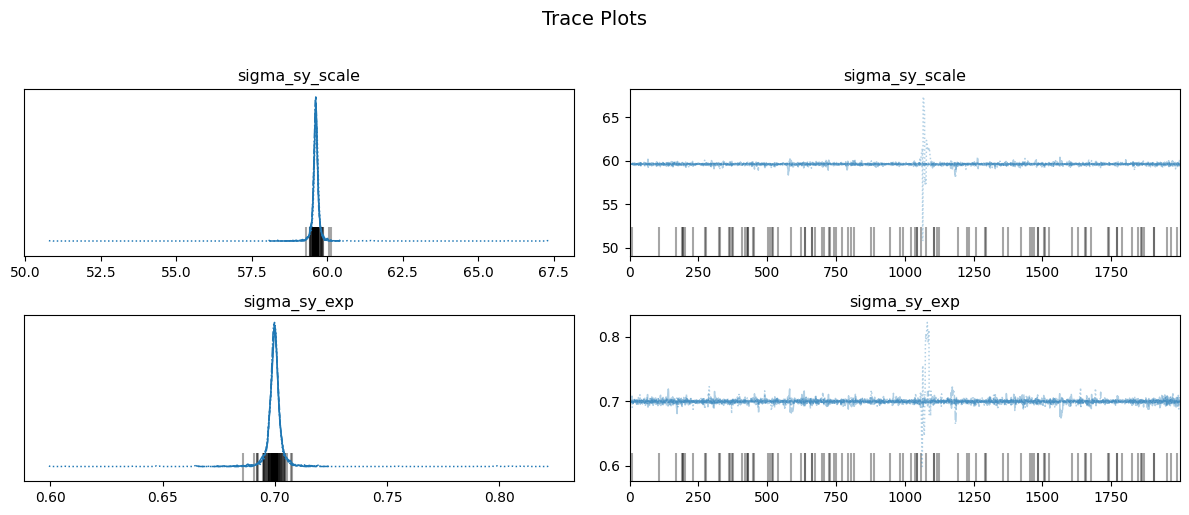

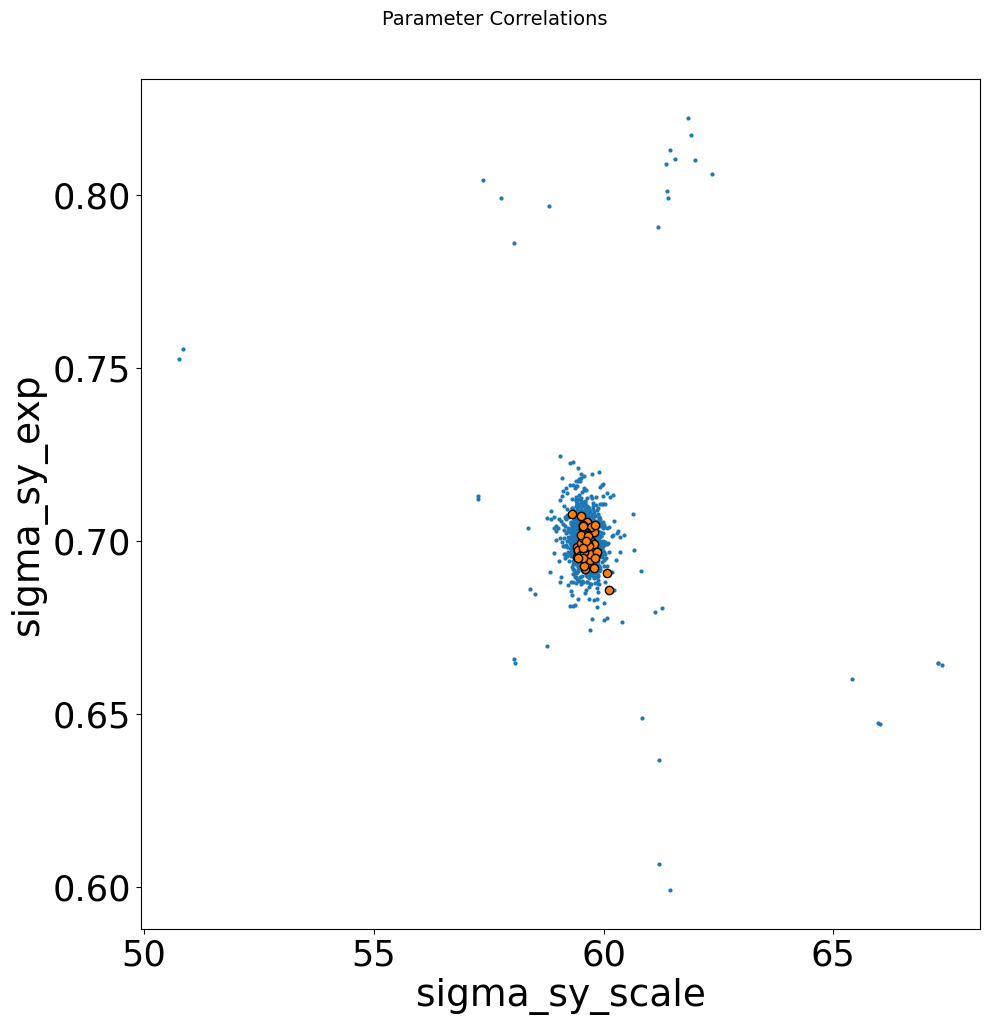

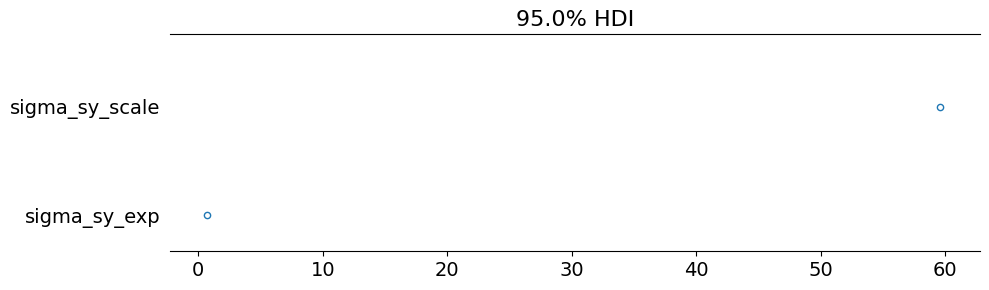

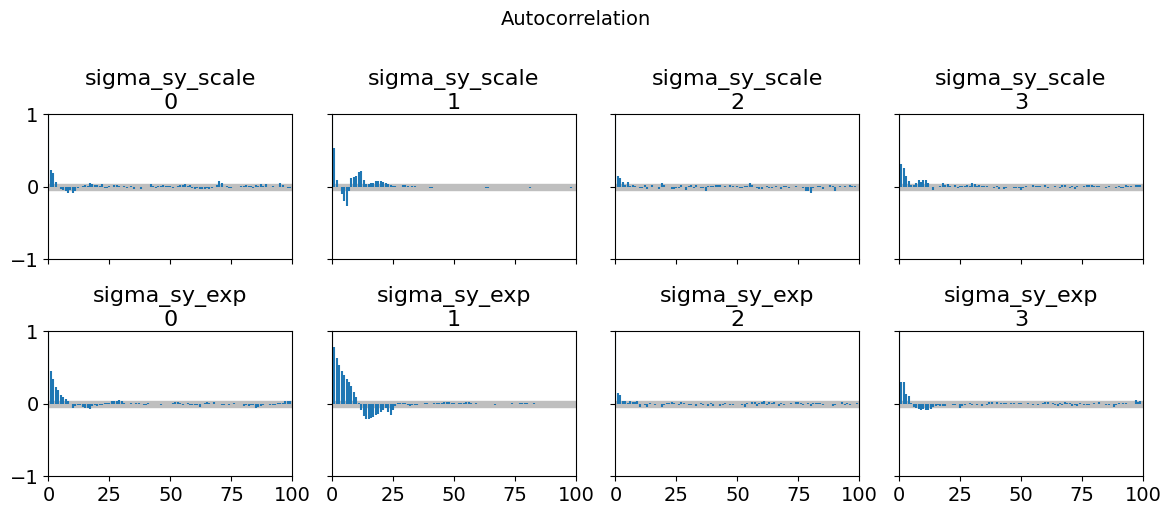

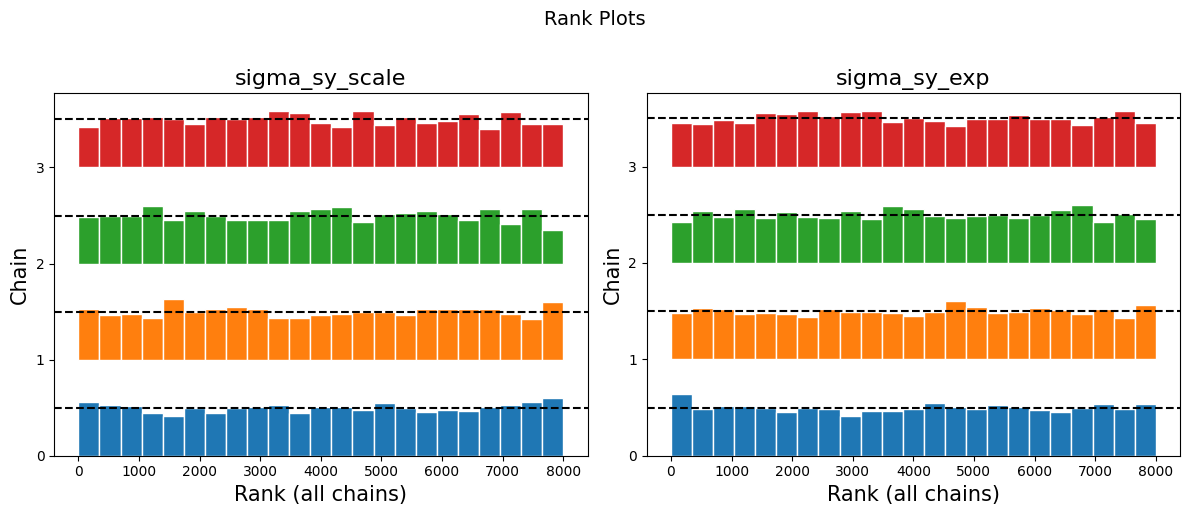

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(bayes, ["sigma_sy_scale", "sigma_sy_exp"], fast_mode=FAST_MODE)

In [12]:
# ArviZ Summary - comprehensive statistics with R-hat and ESS
summary_df = az.summary(idata, var_names=["sigma_sy_scale", "sigma_sy_exp"],
                        hdi_prob=0.94, round_to=4)
print("ArviZ Summary Statistics:")
print(summary_df.to_string())

ArviZ Summary Statistics:
                   mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
sigma_sy_scale  59.6202  0.2802  59.4126  59.8126     0.0047   0.1182  5548.8186  2079.6125  1.0008
sigma_sy_exp     0.7000  0.0058   0.6942   0.7055     0.0002   0.0021  4427.8362  2313.8753  1.0007


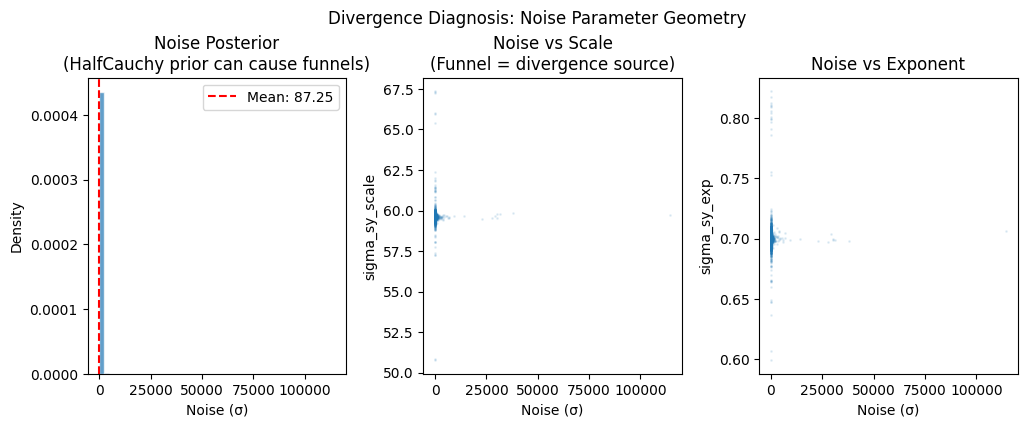

Noise posterior: mean=87.249, std=1589.222
Noise range: [0.0011, 114374.433]

Note: Divergences likely occur when noise → 0 (funnel geometry)
The HalfCauchy(scale=10) prior is too vague for only 5 data points.


In [13]:
# Diagnose divergences: Check if they correlate with the noise parameter
# Divergences often occur in "funnel" geometries where noise → 0
if "noise" in posterior_dict:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    noise_samples = posterior_dict["noise"].flatten()
    scale_samples = posterior_dict["sigma_sy_scale"].flatten()
    exp_samples = posterior_dict["sigma_sy_exp"].flatten()
    
    # Plot noise distribution - check for values near zero
    axes[0].hist(noise_samples, bins=50, density=True, alpha=0.7, edgecolor='white')
    axes[0].axvline(noise_samples.mean(), color='r', ls='--', label=f'Mean: {noise_samples.mean():.2f}')
    axes[0].set_xlabel('Noise (σ)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Noise Posterior\n(HalfCauchy prior can cause funnels)')
    axes[0].legend()
    
    # Noise vs scale - check for funnel shape
    axes[1].scatter(noise_samples, scale_samples, alpha=0.1, s=1)
    axes[1].set_xlabel('Noise (σ)')
    axes[1].set_ylabel('sigma_sy_scale')
    axes[1].set_title('Noise vs Scale\n(Funnel = divergence source)')
    
    # Noise vs exponent
    axes[2].scatter(noise_samples, exp_samples, alpha=0.1, s=1)
    axes[2].set_xlabel('Noise (σ)')
    axes[2].set_ylabel('sigma_sy_exp')
    axes[2].set_title('Noise vs Exponent')
    
    plt.suptitle('Divergence Diagnosis: Noise Parameter Geometry', y=1.02)
    fig.subplots_adjust(top=0.85, wspace=0.3)
    display(fig)
    plt.close(fig)
    
    print(f"Noise posterior: mean={noise_samples.mean():.3f}, std={noise_samples.std():.3f}")
    print(f"Noise range: [{noise_samples.min():.4f}, {noise_samples.max():.3f}]")
    print(f"\nNote: Divergences likely occur when noise → 0 (funnel geometry)")
    print("The HalfCauchy(scale=10) prior is too vague for only 5 data points.")
else:
    print("Noise parameter not found in samples")

## Residual Analysis

The posterior predictive check above shows the residual structure (observed - predicted). For the SPP power-law model:

- **Random scatter**: Model adequately captures yield stress scaling
- **Systematic trends**: May indicate need for more complex yielding model (e.g., Herschel-Bulkley)
- **Outliers**: Check SPP decomposition quality for those amplitudes

With only 5 data points, visual inspection of residuals is sufficient. For larger datasets, consider quantile-quantile plots or runs tests.

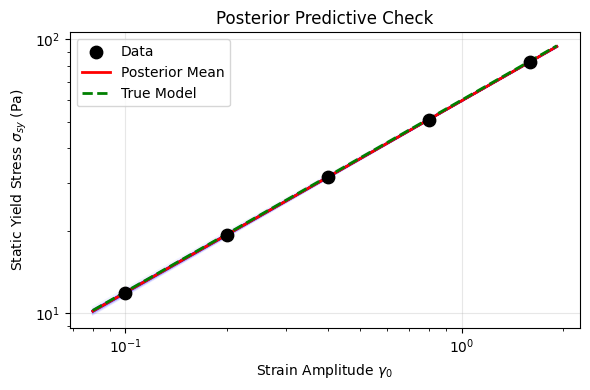

In [14]:
# Posterior predictive check
samples = bayes.posterior_samples
scale_samples = np.array(samples.get("sigma_sy_scale", [])).flatten()
exp_samples = np.array(samples.get("sigma_sy_exp", [])).flatten()

if len(scale_samples) > 0 and len(exp_samples) > 0:
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Data
    gamma_plot = np.array(gamma_levels)
    ax.scatter(gamma_plot, np.array(sigma_sy), s=80, c='black', zorder=5, label='Data')
    
    # Posterior predictive samples
    gamma_fine = np.linspace(gamma_plot.min() * 0.8, gamma_plot.max() * 1.2, 100)
    n_draws = min(100, len(scale_samples))
    for i in range(n_draws):
        pred = scale_samples[i] * gamma_fine ** exp_samples[i]
        ax.plot(gamma_fine, pred, 'b-', alpha=0.05)
    
    # Mean prediction
    mean_pred = scale_samples.mean() * gamma_fine ** exp_samples.mean()
    ax.plot(gamma_fine, mean_pred, 'r-', lw=2, label='Posterior Mean')
    
    # True values
    true_pred = A_true * gamma_fine ** n_true
    ax.plot(gamma_fine, true_pred, 'g--', lw=2, label='True Model')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'Strain Amplitude $\gamma_0$')
    ax.set_ylabel(r'Static Yield Stress $\sigma_{sy}$ (Pa)')
    ax.set_title('Posterior Predictive Check')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    display(fig)
    plt.close(fig)

## Further Reading

- **Rogers (2012)**: ["A sequence of physical processes"](https://doi.org/10.1122/1.3662962) — Complete SPP theory and validation
- **RheoJAX SPP Pipeline**: [Documentation](../../docs/source/pipeline/workflows.rst#spp-amplitude-sweep) — Implementation details
- **Hyun et al. (2011)**: ["Nonlinear oscillatory shear review"](https://doi.org/10.1016/j.progpolymsci.2011.02.002) — Context for LAOS methods
- **NumPyro Hierarchical Models**: [Tutorial](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html) — Understanding noise parameter funnels

## Next Steps

- **[08-spp-laos.ipynb](08-spp-laos.ipynb)**: Detailed SPP theory and single-amplitude decomposition
- **[advanced/10-spp-laos-tutorial.ipynb](../advanced/10-spp-laos-tutorial.ipynb)**: Advanced SPP parameter interpretation
- Apply this workflow to your own LAOS amplitude sweep datasets

**For questions or issues:**
- GitHub: https://github.com/imewei/rheojax/issues
- Documentation: https://rheojax.readthedocs.io

### Key References

- **Rogers, S.A. et al. (2012).** "A sequence of physical processes determined from LAOS." *J. Rheol.* 56:1-25. [Original SPP theory and implementation]
- **Rogers, S.A. & Lettinga, M.P. (2012).** "A sequence of physical processes from LAOS using a simple model." *J. Rheol.* 56:1129-1151. [SPP for complex fluids]
- **Hyun, K. et al. (2011).** "A review of nonlinear oscillatory shear tests." *Prog. Polym. Sci.* 36:1697-1753. [Comprehensive LAOS methods review]

In [15]:
# Final comparison: NLSQ vs Bayesian vs True
print("\n" + "="*60)
print("PARAMETER COMPARISON")
print("="*60)
print(f"{'Parameter':<20} {'True':>10} {'NLSQ':>10} {'Bayesian':>10}")
print("-"*60)
print(f"{'sigma_sy_scale':<20} {A_true:>10.4f} {scale_nlsq:>10.4f} "
      f"{bayes.summary['sigma_sy_scale']['mean']:>10.4f}")
print(f"{'sigma_sy_exp':<20} {n_true:>10.4f} {exp_nlsq:>10.4f} "
      f"{bayes.summary['sigma_sy_exp']['mean']:>10.4f}")
print("="*60)


PARAMETER COMPARISON
Parameter                  True       NLSQ   Bayesian
------------------------------------------------------------
sigma_sy_scale          60.0000    59.6651    59.6202
sigma_sy_exp             0.7000     0.7017     0.7000
